In [1]:
using Plots
using SpecialFunctions
using LinearAlgebra
using FFTW
# using StaticArrays
# using CUDA
using GPUArrays
using BenchmarkTools
using Optim
using Statistics
# using LinearMaps
# using IterativeSolvers
using Test
using ProgressMeter
using HDF5
using Printf
using Flux
using ParallelStencil
@init_parallel_stencil(CUDA, Float64, 3)

In [2]:
# Parallel_Stencil
Float= Float64;
Int= Int32;
# Flux
xpu= gpu;

In [3]:
include("wavelets.jl")
include("Synthetics.jl")
include("utils_bp.jl");

In [4]:
# Time grid
nt = 800
dt= 0.5
fmax= 0.25/dt
tgrid = Float.(range(-200, stop=200, step= dt)); # time samples from -200, 200 seconds
nt= length(tgrid)

# Freq grid
# fgrid= FFTW.rfftfreq(nt);
# nf= length(fgrid);

In [5]:
# Ricker not here

## Source and receiver grids

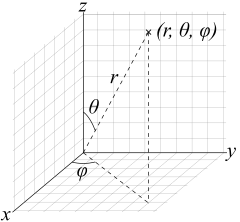
</br> $\theta$ is the azimuthal angle varying from $[-\pi, \pi]$ and $\phi$ is the take-off angle from $[-\pi/2, \pi/2]$. </br> 
In our, the axis pointing towards the north will be the reference for $\theta$, which will be the z-axis in our case, that is, z-axis points towards the north while x-axis points towards the east and y is positive vertically upwards from the earth's surface.

### Receiver grid

In [6]:
dir_path= "/home/abhinav/workspace/Bp/utilities"
load_path= "wave3/mnt"

eq_grid= "chile"

cntr, θ, ϕ, travel_times, network= obspy_data(eq_grid, dir_path, load_path);
# We are not using travel_times (from PREM) anywhere, except to check for limits for Fraunhofer approximation
cntr= polar2cartesian(cntr) # cntr is also not really used anywhere
θ= Float.(π/180 .*θ);
ϕ= Float.(π/180 .*ϕ);
nr= length(θ);

┌ Info: Loading the grid data for chile from the loaded dataset in the saved directory.
└ @ Main /home/abhinav/workspace/EqUtils.jl/src/Backprojection/utils_bp.jl:25


In [7]:
# Filter arrays, if needed. Look utils_bp.jl

cntr, θ, ϕ, travel_times, network, nr, IDs= get_unique_receivers(cntr, θ, ϕ, travel_times, network, nr);
arrays= network;

┌ Info: Number of receivers reduced to 123
└ @ Main /home/abhinav/workspace/EqUtils.jl/src/Backprojection/utils_bp.jl:163


### Source grid

Source grid (Using Fraunhoffer limit): </br>
$W^2< L \lambda$ </br>
For peak frequency, we have the lowest width, for homogeneous velocity we have $W^2= ct_0* c/f_p$ </br>=> $W= c(t_{min}/f_p)^{0.5}$ for the lowest width </br>
* For $f_p= 0.05 Hz$  ,  $t_{min}= 120 sec$, at </br> $c= 2.5 km/s$, </t> $W \approx 122 km$ </br>
$c= 8.0 km/s$, </t> $W \approx 391 km$
</br></br>
* For $f_p= 0.1 Hz$  ,  $t_{min}= 120 sec$, at </br> $c= 2.5 km/s$, </t> $W \approx 85 km$ </br>
 $c= 8.0 km/s$, </t> $W \approx 275 km$

In [8]:
cz,cy,cx= [0., 0., 0.] #Float.([0.,0.,0.])
mcntr= [cz,cy,cx];
dx= 5; dz= 5;
zgrid = Float.(cz.+ range(-150, stop=150, step=dz))
ygrid = Float.(cy.+ [0])
xgrid = Float.(cx.+ range(-150, stop=150, step=dx))
Tgrid = range(-150, 150, step= 1)
mgrid= [zgrid, ygrid, xgrid, Tgrid];
rgrid= [θ,ϕ];
dT= step(Tgrid)
nz, ny, nx, nT= length.(mgrid)

Tshift= Int.(round.(Tgrid./dt))
v0= 8.000 # km/s Velocity around the source grid for Fraunhofer

shift= get_shifts(mgrid, rgrid, v0);

In [23]:
include("forward.jl");

### Checks

Checks for Fraunhofer approximations, here we **check only for 0.1 Hz**, peak frequency of ricker wavelet used in our case. If you know the peak frequency of your data, you may put that here, otherwise for the `tgrid` we have chosen, it won't be larger than `fmax`

In [10]:
fp= 0.1;
if @isdefined(travel_times)
    min_t0= minimum(travel_times);
    W= v0*(min_t0/fp)^0.5
    if nz*dz > W
        @warn("Checking for 0.1 Hz, Fraunhofer condition violated in zgrid"* 
            "Fraunhofer condition is valid for "*string(W)* " km, or "* string(W/111)*" degrees ");
    end
    if nx*dx > W
        @warn("Checking for 0.1 Hz, Fraunhofer condition violated in xgrid"* 
            "Fraunhofer condition is valid for "*string(W)* " km, or "* string(W/111)*" degrees ");
    end
else
    min_t0= 120;
    @info("Assuming minimum travel time from center to any receiver is 120 s.")
    W= v0*(min_t0/fp)^0.5
    if nz*dz > W
        @warn("Checking for 0.1 Hz, Fraunhofer condition violated in zgrid"* 
            "Fraunhofer condition is valid for "*string(W)* " km, or "* string(W/111)*" degrees ");
    end
    if nx*dx > W
        @warn("Checking for 0.1 Hz, Fraunhofer condition violated in xgrid"* 
            "Fraunhofer condition is valid for "*string(W)* " km, or "* string(W/111)*" degrees ");
    end
end

In [11]:
# function source for putting m[sloc...]= 1, and get 

In [12]:
ricker(t)= rick(0.1, t)

ricker (generic function with 1 method)

## Synthetics

In [13]:
dobs= xpu(zeros(nt, nr));

In [14]:
@time source!(dobs, mgrid, rgrid, v0, mcntr, 11, 1, 55, 101);# Int.(zloc), Int.(yloc), Int.(xloc), Int.(idels));

 10.671846 seconds (25.65 M allocations: 1.366 GiB, 2.75% gc time, 31.20% compilation time)


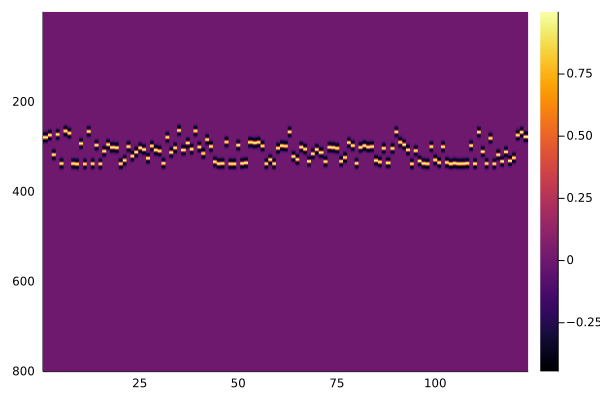

In [15]:
heatmap(cpu(dobs), yflip= true)

## Real

Load real data into (nt,nr) array

## G and G'

In [16]:
rickg= fill(Float(0.), nt, 1, 1, 1, 1, 1) |>xpu; # ricker
# fg= fill(0 .+ im*0., nf, 1, 1,1,1,1)|>xpu; # fgrid
shiftg= fill(Int(0), 1, nr, nz, ny, nx, 1)|>xpu; # time shifts
Tshiftg= fill(Int(0), 1,1,1,1,1,nT)|>xpu; #time shits for temporal domain

In [17]:
@allowscalar copyto!(view(rickg, :, 1, 1, 1, 1, 1), ricker.(tgrid))# ;FFTW.rfft(r));
# @allowscalar copyto!(view(fg, :, 1, 1, 1, 1, 1), fgrid);
@allowscalar copyto!(view(shiftg, 1 , :, :, :, :, 1), permutedims(shift, [4, 1, 2, 3]));
@allowscalar copyto!(view(Tshiftg, 1, 1, 1, 1, 1, :), Tshift);

In [18]:
delay= broadcast(+, shiftg, Tshiftg);
(lb, ub)= extrema(tgrid)./dt .+ extrema(cpu(delay));

exp_tgrid= Float.(dt.*(lb:ub));#range(lb,ub, step= dt);
rick0= Float.(ricker.(exp_tgrid)) |>xpu;

In [19]:
dg= zeros(Float, nt, nr) |>xpu;
mg= zeros(Float, nz, ny, nx, nT) |>xpu;

In [20]:
@allowscalar mg[11, 1, 55, 101]= 1.;

In [24]:
G!(d,m)= G_ps!(d, m, delay, nt, nr, nz, ny, nx, nT, rick0, mvec, dvec, Int(abs(lb)));
Gt!(grad, ∇d)= Gt_ps!(grad, ∇d, delay, nt, nr, nz, ny, nx, nT, rick0, g2, grvec, ddvec, Int(abs(lb)));

In [25]:
@time G!(dg, mg);

  5.793737 seconds (15.69 M allocations: 831.741 MiB, 4.38% gc time, 43.22% compilation time)


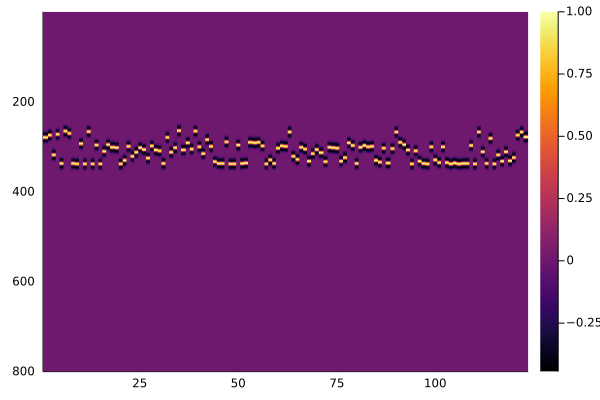

In [26]:
heatmap(cpu(dg), yflip= true)

In [27]:
grad= zeros(nz,ny,nx,nT) |>xpu;

In [28]:
Gt!(grad, dobs);

In [29]:
#anim= Plots.Animation()
anim= @animate for i in 1:nT
    heatmap(xgrid, zgrid, real.(cpu(grad)[:,1,:,i]), yflip= true, title= string(i), clims= (0.8 *minimum(real.(cpu(grad))), 1.2*maximum(real.(cpu(grad)))))
end

Animation("/tmp/jl_pqPrGJ", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000292.png", "000293.png", "000294.png", "000295.png", "000296.png", "000297.png", "000298.png", "000299.png", "000300.png", "000301.png"])

┌ Info: Saved animation to 
│   fn = /home/abhinav/workspace/EqUtils.jl/src/Backprojection/tmp.gif
└ @ Plots /home/abhinav/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/abhinav/workspace/EqUtils.jl/src/Backprojection/tmp.gif")
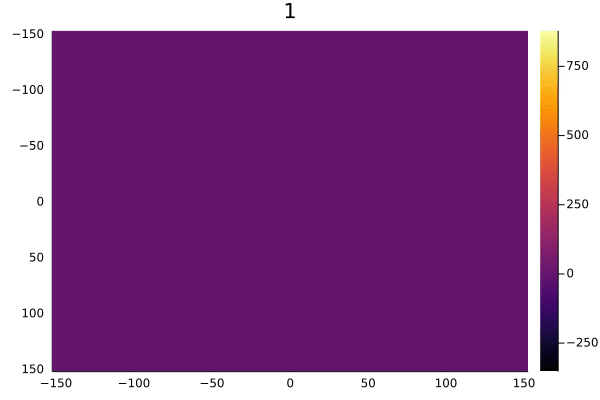

In [30]:
gif(anim)